In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

# Optional untuk preprocessing
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('indonesian'))  # gunakan 'english' jika data dalam bahasa Inggris


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/macintoshhd/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


l

In [2]:
# Load dataset
df = pd.read_csv('DatasetTerbaru.csv')

# Tampilkan 5 data teratas
print(df.head())


   label                                              tweet  \
0  anger  Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...   
1  anger  Sesama cewe lho (kayaknya), harusnya bisa lebi...   
2  happy  Kepingin gudeg mbarek Bu hj. Amad Foto dari go...   
3  anger  Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...   
4  happy  Sharing pengalaman aja, kemarin jam 18.00 bata...   

                       rekomendasi_makanan  
0      Tahu bulat, Rujak buah, Sosis bakar  
1    Ayam teriyaki, Tahu isi, Bihun goreng  
2     Brownies, Bubble tea, Es krim vanila  
3  Kerupuk udang, Siomay, Keripik singkong  
4     Kentang spiral, Kue sus, Nasi kuning  


EDA

In [3]:
# Menampilkan beberapa baris pertama
display(df.head())

# Menampilkan info dataset
df.info()

,label,tweet,rekomendasi_makanan
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...","Tahu bulat, Rujak buah, Sosis bakar"
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi...","Ayam teriyaki, Tahu isi, Bihun goreng"
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,"Brownies, Bubble tea, Es krim vanila"
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...","Kerupuk udang, Siomay, Keripik singkong"
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata...","Kentang spiral, Kue sus, Nasi kuning"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2120 entries, 0 to 2119
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   label                2120 non-null   object
 1   tweet                2120 non-null   object
 2   rekomendasi_makanan  2120 non-null   object
dtypes: object(3)
memory usage: 49.8+ KB


In [4]:
# Cek nilai yang hilang
print("\nNilai yang hilang per kolom:")
print(df.isnull().sum())



Nilai yang hilang per kolom:
label                  0
tweet                  0
rekomendasi_makanan    0
dtype: int64


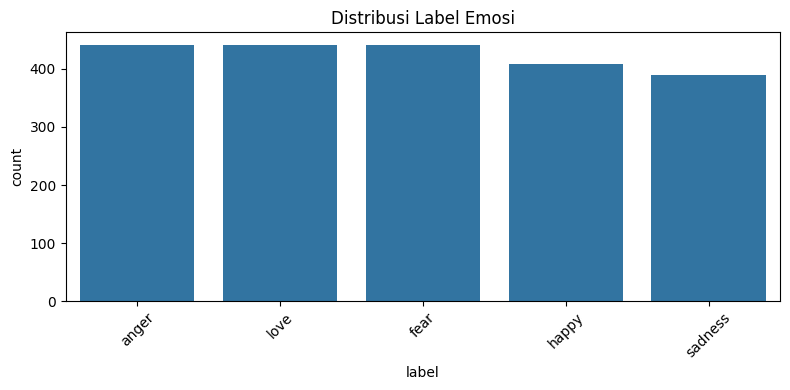

In [5]:
# Distribusi kategori target
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
plt.title("Distribusi Label Emosi")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [6]:
# Menambah kolom panjang teks
df['panjang_teks'] = df['tweet'].apply(lambda x: len(str(x).split()))
display(df[['tweet', 'panjang_teks']].head())

,tweet,panjang_teks
0,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",27
1,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",35
2,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,17
3,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...",32
4,"Sharing pengalaman aja, kemarin jam 18.00 bata...",30


In [7]:
# Statistik panjang kata
print("\nStatistik panjang kata:")
print(df['panjang_teks'].describe())


Statistik panjang kata:
count    2120.000000
mean       22.873585
std        12.568118
min         5.000000
25%         9.000000
50%        24.000000
75%        33.000000
max        57.000000
Name: panjang_teks, dtype: float64


In [8]:
print("Jumlah data:", df.shape)
print("Kolom yang tersedia:", df.columns)


Jumlah data: (2120, 4)
Kolom yang tersedia: Index(['label', 'tweet', 'rekomendasi_makanan', 'panjang_teks'], dtype='object')


In [9]:
df = df[['tweet', 'label']]  # ganti jika nama kolom berbeda
df.dropna(inplace=True)


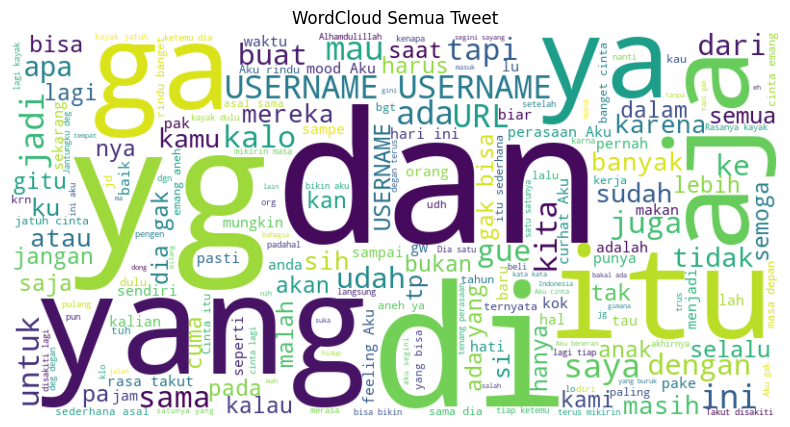

In [10]:

# WordCloud
all_text = " ".join(df['tweet'].astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud Semua Tweet")
plt.show()

In [11]:
# 20 kata paling sering muncul
tokens = all_text.lower().split()
common_words = Counter(tokens).most_common(20)
common_words_df = pd.DataFrame(common_words, columns=['Kata', 'Frekuensi'])
print("\n20 Kata Paling Sering Muncul:")
display(common_words_df)


20 Kata Paling Sering Muncul:


,Kata,Frekuensi
0,yang,648
1,aku,628
2,dan,607
3,yg,587
4,di,552
5,[username],528
6,itu,364
7,ada,339
8,gak,313
9,sama,309


Prepocesing

cleaning

In [12]:
import pandas as pd
import re

# Contoh: jika df adalah DataFrame awal kamu
# df = pd.read_csv('Dataset_emoticon_balanced.csv')

# Salin kolom asli untuk dianalisis
df_cleaning = df[['tweet']].copy()
df_cleaning['original'] = df_cleaning['tweet']

# Lowercase + Cleaning karakter
df_cleaning['cleaned'] = df_cleaning['tweet'].str.lower().apply(lambda x: re.sub(r'[^a-z\s]', '', x))

# Tampilkan hasilnya
df_cleaning[['original', 'cleaned']].head()


,original,cleaned
0,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",soal jln jatibarupolisi tdk bs gertak gubernur...
1,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",sesama cewe lho kayaknya harusnya bisa lebih r...
2,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,kepingin gudeg mbarek bu hj amad foto dari goo...
3,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...",jln jatibarubagian dari wilayah tn abangpengat...
4,"Sharing pengalaman aja, kemarin jam 18.00 bata...",sharing pengalaman aja kemarin jam batalin ti...


lowercase

In [13]:
import pandas as pd

# Salin kolom asli untuk analisis
df_lower = df[['tweet']].copy()
df_lower['original'] = df_lower['tweet']

# Terapkan lowercasing
df_lower['lowercased'] = df_lower['tweet'].str.lower()

# Tampilkan hasilnya
df_lower[['original', 'lowercased']].head()


,original,lowercased
0,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...","soal jln jatibaru,polisi tdk bs gertak gubernu..."
1,"Sesama cewe lho (kayaknya), harusnya bisa lebi...","sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,kepingin gudeg mbarek bu hj. amad foto dari go...
3,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...","jln jatibaru,bagian dari wilayah tn abang.peng..."
4,"Sharing pengalaman aja, kemarin jam 18.00 bata...","sharing pengalaman aja, kemarin jam 18.00 bata..."


stopword

In [14]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS  # sementara pakai dari sklearn
# Untuk bahasa Indonesia, kamu bisa ganti ke daftar stopword Bahasa Indonesia secara manual

# Contoh stopword Indonesia sederhana (kamu bisa kembangkan daftarnya)
stopwords_id = set([
    'yang', 'di', 'ke', 'dari', 'dengan', 'untuk', 'pada', 'adalah', 'itu',
    'dan', 'atau', 'ini', 'karena', 'jika', 'agar', 'sehingga', 'dalam', 'sudah'
])

# Ambil data dan lakukan preprocessing dasar dulu
df_stop = df[['tweet']].copy()
df_stop['original'] = df_stop['tweet']

# Lowercasing + Cleaning
df_stop['cleaned'] = df_stop['tweet'].str.lower().apply(lambda x: re.sub(r'[^a-z\s]', '', x))

# Tokenisasi (pakai split)
df_stop['tokenized'] = df_stop['cleaned'].apply(lambda x: x.split())

# Stopword removal
df_stop['stopword_removed'] = df_stop['tokenized'].apply(lambda tokens: [word for word in tokens if word not in stopwords_id])

# Tampilkan hasil sebelum dan sesudah stopword removal
df_stop[['original', 'tokenized', 'stopword_removed']].head()


,original,tokenized,stopword_removed
0,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...","[soal, jln, jatibarupolisi, tdk, bs, gertak, g...","[soal, jln, jatibarupolisi, tdk, bs, gertak, g..."
1,"Sesama cewe lho (kayaknya), harusnya bisa lebi...","[sesama, cewe, lho, kayaknya, harusnya, bisa, ...","[sesama, cewe, lho, kayaknya, harusnya, bisa, ..."
2,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,"[kepingin, gudeg, mbarek, bu, hj, amad, foto, ...","[kepingin, gudeg, mbarek, bu, hj, amad, foto, ..."
3,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...","[jln, jatibarubagian, dari, wilayah, tn, abang...","[jln, jatibarubagian, wilayah, tn, abangpengat..."
4,"Sharing pengalaman aja, kemarin jam 18.00 bata...","[sharing, pengalaman, aja, kemarin, jam, batal...","[sharing, pengalaman, aja, kemarin, jam, batal..."


steeming

In [15]:
def simple_stemmer(word):
    # Hapus awalan umum
    for prefix in ['ber', 'ter', 'se', 'me', 'di', 'ke']:
        if word.startswith(prefix):
            word = word[len(prefix):]
            break
    
    # Hapus akhiran umum
    for suffix in ['kan', 'an', 'i']:
        if word.endswith(suffix):
            word = word[:-len(suffix)]
            break
            
    return word

# Terapkan stemming ke data hasil stopword removal
df_stem = df_stop.copy()
df_stem['before_stemming'] = df_stem['stopword_removed']
df_stem['after_stemming'] = df_stem['stopword_removed'].apply(lambda tokens: [simple_stemmer(word) for word in tokens])

# Tampilkan hasil
df_stem[['original', 'before_stemming', 'after_stemming']].head()


,original,before_stemming,after_stemming
0,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...","[soal, jln, jatibarupolisi, tdk, bs, gertak, g...","[soal, jln, jatibarupolis, tdk, bs, gertak, gu..."
1,"Sesama cewe lho (kayaknya), harusnya bisa lebi...","[sesama, cewe, lho, kayaknya, harusnya, bisa, ...","[sama, cewe, lho, kayaknya, harusnya, bisa, le..."
2,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,"[kepingin, gudeg, mbarek, bu, hj, amad, foto, ...","[pingin, gudeg, mbarek, bu, hj, amad, foto, go..."
3,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...","[jln, jatibarubagian, wilayah, tn, abangpengat...","[jln, jatibarubagi, wilayah, tn, abangpengatur..."
4,"Sharing pengalaman aja, kemarin jam 18.00 bata...","[sharing, pengalaman, aja, kemarin, jam, batal...","[sharing, pengalam, aja, marin, jam, batalin, ..."


tokenization

In [16]:
# Salin dari hasil lowercasing dan cleaning sebelumnya
df_token = df_cleaning[['cleaned']].copy()
df_token['original'] = df_token['cleaned']

# Tokenization: pisahkan kata berdasarkan spasi
df_token['tokenized'] = df_token['cleaned'].apply(lambda x: x.split())

# Tampilkan hasil
df_token[['original', 'tokenized']].head()


,original,tokenized
0,soal jln jatibarupolisi tdk bs gertak gubernur...,"[soal, jln, jatibarupolisi, tdk, bs, gertak, g..."
1,sesama cewe lho kayaknya harusnya bisa lebih r...,"[sesama, cewe, lho, kayaknya, harusnya, bisa, ..."
2,kepingin gudeg mbarek bu hj amad foto dari goo...,"[kepingin, gudeg, mbarek, bu, hj, amad, foto, ..."
3,jln jatibarubagian dari wilayah tn abangpengat...,"[jln, jatibarubagian, dari, wilayah, tn, abang..."
4,sharing pengalaman aja kemarin jam batalin ti...,"[sharing, pengalaman, aja, kemarin, jam, batal..."


TFIDF

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Gabungkan token menjadi string
df_tfidf = df_stem.copy()
df_tfidf['text_final'] = df_tfidf['after_stemming'].apply(lambda x: ' '.join(x))

# Inisialisasi TF-IDF Vectorizer
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df_tfidf['text_final'])

# Konversi hasilnya ke DataFrame (opsional untuk lihat isinya)
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

# Tampilkan beberapa baris hasil vectorisasi
tfidf_df.head()


,aa,aaa,aaaaaaa,aaaaak,aaah,aaahhhh,aaamiiinnn,aalamiin,aamiiin,aamiin,...,zam,zamannya,zeratu,zero,zhon,zina,zmn,zon,zona,zonk
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


split data

In [18]:
from sklearn.model_selection import train_test_split

# Pastikan kolom 'label' ditambahkan ke df_tfidf
df_tfidf['label'] = df['label']

# Label target
y = df_tfidf['label']

# Split data 80% train dan 20% test
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)


In [19]:
df = pd.read_csv('DatasetTerbaru.csv')
print(df.columns)


Index(['label', 'tweet', 'rekomendasi_makanan'], dtype='object')


In [20]:
print(df_tfidf.columns)


Index(['tweet', 'original', 'cleaned', 'tokenized', 'stopword_removed',
       'before_stemming', 'after_stemming', 'text_final', 'label'],
      dtype='object')


In [21]:
# Salin dari df utama agar kolom label tidak hilang
df_tfidf = df_stem.copy()
df_tfidf['text_final'] = df_tfidf['after_stemming'].apply(lambda x: ' '.join(x))

# Tambahkan kolom label dari df asli jika belum ada
if 'label' not in df_tfidf.columns:
    df_tfidf['label'] = df['label']


evaluasi model

In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

from sklearn.metrics import precision_score, recall_score, f1_score

# Inisialisasi dan latih model
model = MultinomialNB()
model.fit(X_train, y_train)

# Prediksi
y_pred = model.predict(X_test)



# Laporan lengkap: precision, recall, f1 per kelas & macro avg
report = classification_report(y_test, y_pred, digits=4)
print("\nClassification Report:\n", report)


# Akurasi
accuracy = accuracy_score(y_test, y_pred)

# Macro Average
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f"Akurasi       : {accuracy:.4f}")
print(f"Precision : {precision_macro:.4f}")
print(f"Recall   : {recall_macro:.4f}")
print(f"F1-Score : {f1_macro:.4f}")




Classification Report:
               precision    recall  f1-score   support

       anger     0.5923    0.8750    0.7064        88
        fear     0.8947    0.7727    0.8293        88
       happy     0.7424    0.5976    0.6622        82
        love     0.9500    0.8636    0.9048        88
     sadness     0.5417    0.5000    0.5200        78

    accuracy                         0.7288       424
   macro avg     0.7442    0.7218    0.7245       424
weighted avg     0.7490    0.7288    0.7302       424

Akurasi       : 0.7288
Precision : 0.7442
Recall   : 0.7218
F1-Score : 0.7245


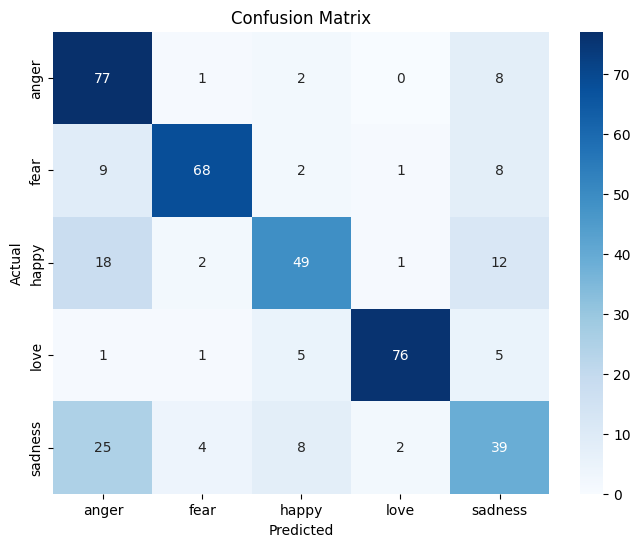

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


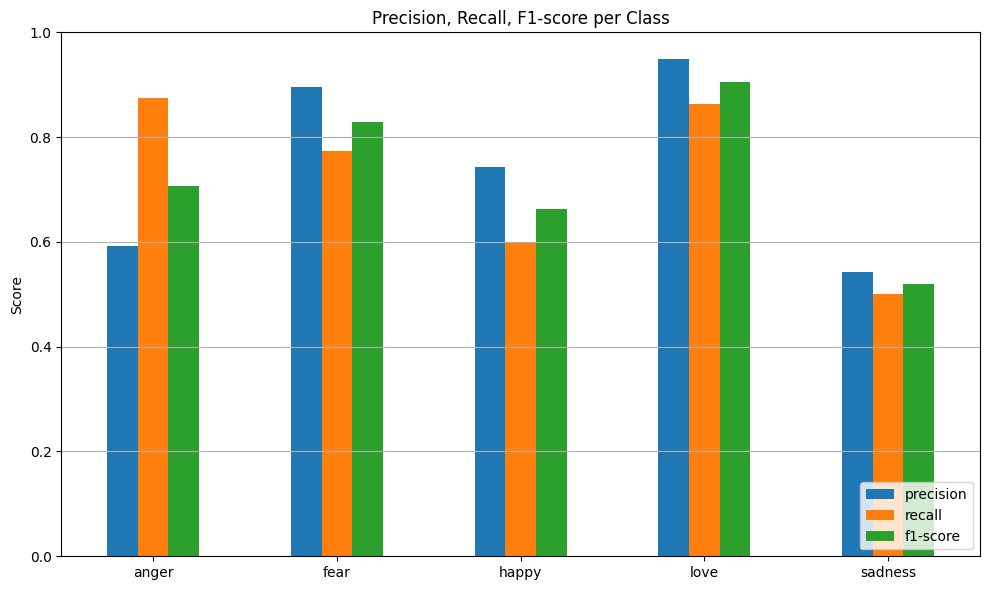

In [24]:
import pandas as pd

# Buat dataframe dari classification_report
report_dict = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()

# Ambil hanya kelas (tanpa avg/accuracy)
df_kelas = df_report.iloc[:-3][['precision', 'recall', 'f1-score']]

# Plot bar
df_kelas.plot(kind='bar', figsize=(10,6))
plt.title("Precision, Recall, F1-score per Class")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


tuning

In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Grid parameter
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]
}

# Inisialisasi model
nb = MultinomialNB()

# Grid Search dengan cross-validation 5-fold dan macro f1-score sebagai metrik
grid = GridSearchCV(nb, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid.fit(X_train, y_train)

# Gunakan model terbaik
best_nb = grid.best_estimator_
y_pred_best = best_nb.predict(X_test)

# Evaluasi makro
accuracy = accuracy_score(y_test, y_pred_best)
precision_macro = precision_score(y_test, y_pred_best, average='macro')
recall_macro = recall_score(y_test, y_pred_best, average='macro')
f1_macro = f1_score(y_test, y_pred_best, average='macro')

# Cetak hasil
print("Best Parameters:", grid.best_params_)
print(f"Akurasi       : {accuracy:.4f}")
print(f"Precision (Macro Avg): {precision_macro:.4f}")
print(f"Recall    (Macro Avg): {recall_macro:.4f}")
print(f"F1-Score  (Macro Avg): {f1_macro:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_best, digits=4))


Best Parameters: {'alpha': 0.1}
Akurasi       : 0.7028
Precision (Macro Avg): 0.7300
Recall    (Macro Avg): 0.6994
F1-Score  (Macro Avg): 0.7084

Classification Report:

              precision    recall  f1-score   support

       anger     0.6327    0.7045    0.6667        88
        fear     0.9565    0.7500    0.8408        88
       happy     0.5802    0.5732    0.5767        82
        love     1.0000    0.8409    0.9136        88
     sadness     0.4804    0.6282    0.5444        78

    accuracy                         0.7028       424
   macro avg     0.7300    0.6994    0.7084       424
weighted avg     0.7380    0.7028    0.7142       424



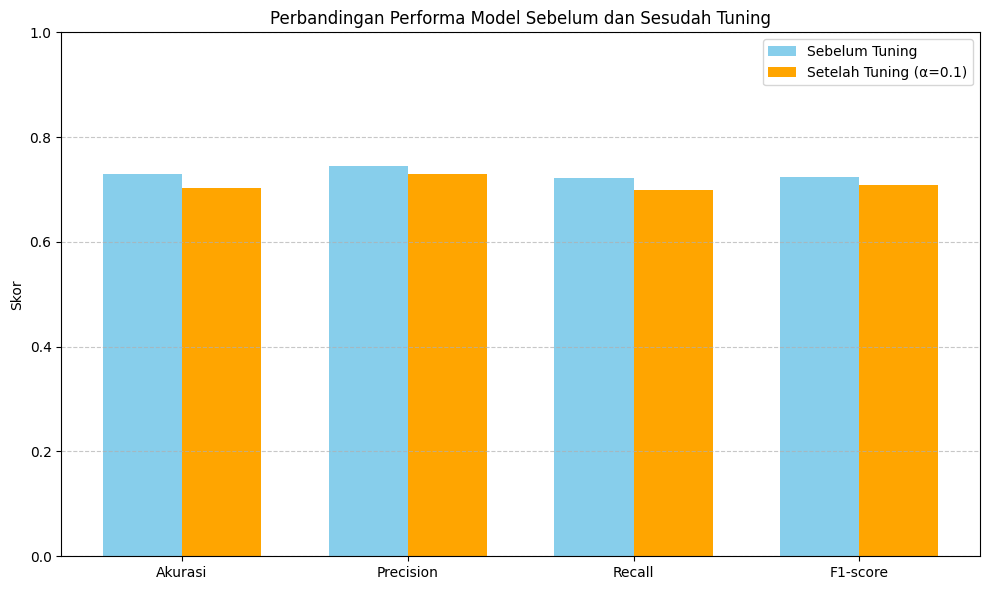

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Nilai metrik sebelum tuning
metrics_before = {
    'Akurasi': 0.7288,
    'Precision': 0.7442,
    'Recall': 0.7218,
    'F1-score': 0.7245
}

# Nilai metrik setelah tuning
metrics_after = {
    'Akurasi': 0.7028,
    'Precision': 0.7300,
    'Recall': 0.6994,
    'F1-score': 0.7084
}

# Nama metrik
labels = list(metrics_before.keys())

# Ambil nilai metrik
before_values = list(metrics_before.values())
after_values = list(metrics_after.values())

# Posisi batang
x = np.arange(len(labels))
width = 0.35

# Buat plot
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, before_values, width, label='Sebelum Tuning', color='skyblue')
plt.bar(x + width/2, after_values, width, label='Setelah Tuning (α=0.1)', color='orange')

# Label dan judul
plt.ylabel('Skor')
plt.title('Perbandingan Performa Model Sebelum dan Sesudah Tuning')
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [26]:
import pickle

with open("model_naivebayes_best.pkl", "wb") as f:
    pickle.dump(model, f)

with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)


In [27]:
print(df.head())

   label                                              tweet  \
0  anger  Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...   
1  anger  Sesama cewe lho (kayaknya), harusnya bisa lebi...   
2  happy  Kepingin gudeg mbarek Bu hj. Amad Foto dari go...   
3  anger  Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...   
4  happy  Sharing pengalaman aja, kemarin jam 18.00 bata...   

                       rekomendasi_makanan  
0      Tahu bulat, Rujak buah, Sosis bakar  
1    Ayam teriyaki, Tahu isi, Bihun goreng  
2     Brownies, Bubble tea, Es krim vanila  
3  Kerupuk udang, Siomay, Keripik singkong  
4     Kentang spiral, Kue sus, Nasi kuning  


In [28]:
print(df.columns)

Index(['label', 'tweet', 'rekomendasi_makanan'], dtype='object')


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import pickle
import pandas as pd

# Load data
df = pd.read_csv("DatasetTerbaru.csv")  # pastikan ini file yang benar

# Preprocessing (pakai yang sudah kamu punya jika ada)
df['text_final'] = df['tweet'].astype(str).str.lower()

# Vectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['text_final'])

# Model
model = MultinomialNB()
model.fit(X, df['label'])  # atau kolom target yang sesuai

# Simpan vectorizer dan model BERSAMAAN
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

with open("model_naivebayes_best.pkl", "wb") as f:
    pickle.dump(model, f)
